In [1]:
import razor.flow as rf
from razor import api
import logging
import time, os
import typing as typ
import numpy as np
import pandas as pd

logger = logging.getLogger()

In [2]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)


In [3]:
@rf.block(executor=rf.FunctionExecutor)
class STDIn:
    filename: str
    records: int
    out_ds: rf.SeriesOutput[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        with open(project_space_path(self.filename), 'r') as f:
            text_str = f.read()

        logger.info(len(text_str))
        for _ in range(self.records):
            self.out_ds.put(text_str)

            
@rf.block(executor=rf.FunctionExecutor)
class ReplaceChar:
    in_ds: rf.SeriesInput[typ.Any]
    out_ds: rf.SeriesOutput[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        for i in self.in_ds:
            text_str = i.replace('r', '!!!R!!!')
            self.out_ds.put(text_str)
            
            
@rf.block(executor=rf.FunctionExecutor)         
class PrintReplaceFreq:
    s_in_ds: rf.SeriesInput[typ.Any]
    l_in_ds: rf.SeriesInput[typ.Any]
    s_out_ds: rf.SeriesOutput[typ.Any] = rf.Output(transport=rf.KafkaTransport)
    l_out_ds: rf.SeriesOutput[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        logger.info('small')
        for i in self.s_in_ds:
            logger.info(i.count('!!!R!!!'))
            self.s_out_ds.put(i)
            
        logger.info('big')
        for i in self.l_in_ds:
            logger.info(i.count('!!!R!!!'))
            self.l_out_ds.put(i)
            
            
@rf.block(executor=rf.FunctionExecutor) 
class DeReplaceChar:
    in_ds: rf.SeriesInput[typ.Any]
    out_ds: rf.SeriesOutput[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        for i in self.in_ds:
            text_str = i.replace('!!!R!!!', 'r')
            self.out_ds.put(text_str)


@rf.block(executor=rf.FunctionExecutor) 
class STDOut:
    in_ds: rf.SeriesInput[typ.Any]
    out_filename: str

    def run(self):
        text_str = ''
        for i in self.in_ds:
            if len(text_str) == 0:
                text_str = i
            else:
                continue
        logger.info(len(text_str))
        with open(project_space_path(self.out_filename), 'w') as f:
            f.write(text_str)
            

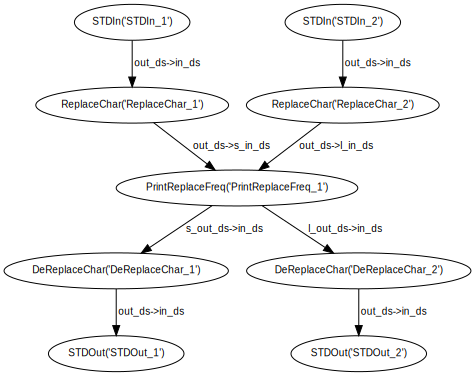

In [4]:
records = 10
s_size = '10MB'
l_size = '100MB'
s_ip_filename = "sdk_testbench/input_data/file" + s_size + ".txt"
l_ip_filename = "sdk_testbench/input_data/file" + l_size + ".txt"
s_op_filename = "sdk_testbench/output_data/s_tc_23.txt"
l_op_filename = "sdk_testbench/output_data/l_tc_23.txt"

s_std_in = STDIn(records=records, filename=s_ip_filename)
l_std_in = STDIn(records=records, filename=l_ip_filename)
l_std_in.out_ds = rf.Output.set(transport=rf.FileTransport)

s_rep_char = ReplaceChar(in_ds=s_std_in.out_ds)
l_rep_char = ReplaceChar(in_ds=l_std_in.out_ds)
l_rep_char.out_ds = rf.Output.set(transport=rf.FileTransport)

print_rep_freq = PrintReplaceFreq(s_in_ds=s_rep_char.out_ds, l_in_ds=l_rep_char.out_ds)
print_rep_freq.l_out_ds = rf.Output.set(transport=rf.FileTransport)

s_derep_char = DeReplaceChar(in_ds=print_rep_freq.s_out_ds)
l_derep_char = DeReplaceChar(in_ds=print_rep_freq.l_out_ds)
l_derep_char.out_ds = rf.Output.set(transport=rf.FileTransport)

s_stdout = STDOut(in_ds=s_derep_char.out_ds, out_filename=s_op_filename)
l_stdout = STDOut(in_ds=l_derep_char.out_ds, out_filename=l_op_filename)

pipeline = rf.Pipeline(name='mix_series_parallel', targets=[s_stdout, l_stdout])
pipeline

In [ ]:
pipeline.execute()

log path: /tmp/tmpvprbkqb2/mix_series_parallel
